In [1]:
!pip install mtcnn

In [0]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import mtcnn
import matplotlib.pyplot as plt
import os 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
import tensorflow  as tf
import tensorflow.keras  as keras
from mtcnn.mtcnn import MTCNN

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# face detection
def extract_face(img, required_size=(160, 160)):
    image = Image.open(img)
    image = image.convert('RGB')
    pixels = np.asarray(image)


    # create an MTCNN face detector class and use it to detect all faces in the loaded photograph
    detector = mtcnn.MTCNN()
    results = detector.detect_faces(pixels)

    # if there is only one face in the photo
    # we can determine the pixel coordinates of the bounding box
    if results != []:
        x1, y1, width, height = results[0]['box']
        x1, y1 = np.abs(x1), np.abs(y1)     # bug fix
        x2, y2 = x1 + width, y1 + height

        # we can use these coordinates to extract the face
        face = pixels[y1:y2, x1:x2]

        # use the PIL library to resize the small image of the face to the required size;
        # note: the model expects square input faces with shape 160 x 160
        image = Image.fromarray(face)
        image = image.resize(required_size)
        face_array = np.asarray(image)
        
        return face_array
    else:
        return None
    

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)
15 (160, 160, 3)
16 (160, 160, 3)


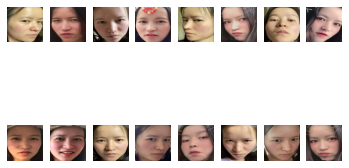

In [5]:
# specify folder for testing
folder = '/content/gdrive/My Drive/dataset2/training/olivia/'
i = 1
for img in os.listdir(folder):
	# path
    path = folder + img
    #print(path)
    #get face
    face = extract_face(path)
    print(i, face.shape)
    #plot
    plt.subplot(2, 8, i)
    plt.axis('off')
    plt.imshow(face)
    i += 1
plt.show()

In [0]:
# define a function to load face into a list 
# extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    for filename in os.listdir(directory):
        path = directory + filename
        face = extract_face(path)
        if (faces != None):
            faces.append(face)
    return faces

def load_dataset(directory):
    X, y = list(), list()
    for subdir in os.listdir(directory):
        path = directory + subdir + '/'

        # skip any files that might be in the dir
        if not os.path.isdir(path):
            continue
        faces = load_faces(path)

        # create labels
        labels = [subdir for _ in range(len(faces))]
        print('>loaded %d examples for class: %s' % (len(faces), subdir))

        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [7]:
# load train dataset
trainX, trainy = load_dataset('/content/gdrive/My Drive/dataset2/training/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/gdrive/My Drive/dataset2/testing/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
np.savez_compressed('dataset.npz', trainX, trainy, testX, testy)

>loaded 16 examples for class: yangzhiting
>loaded 16 examples for class: jiayue
>loaded 16 examples for class: zhouguanghui
>loaded 16 examples for class: xiwei
>loaded 16 examples for class: lora
>loaded 16 examples for class: mag
>loaded 16 examples for class: yuting
>loaded 16 examples for class: huangjenney
>loaded 16 examples for class: olivia
>loaded 16 examples for class: lilewei
(160,) (160,)
>loaded 4 examples for class: jiayue
>loaded 4 examples for class: zhouguanghui
>loaded 4 examples for class: xiwei
>loaded 4 examples for class: lora
>loaded 4 examples for class: mag
>loaded 4 examples for class: yuting
>loaded 4 examples for class: olivia
>loaded 4 examples for class: huangjenney
>loaded 4 examples for class: yangzhiting
>loaded 4 examples for class: lilewei
(40,) (40,)


In [8]:
# load the face dataset
data = np.load('dataset.npz', allow_pickle=True)
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)


Loaded:  (160,) (160,) (40,) (40,)


In [0]:
#################################################################################
# To extract an embedding, 
# first the pixel values of the image need to be suitably prepared 
# to meet the expectations of the FaceNet model. 
# This specific implementation of the FaceNet model expects that the pixel values are standardized.
#################################################################################
# scale pixel values
# face_pixels = trainX[0]
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std

    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)

    yhat = model.predict(samples)
    # get embedding
    embedding = yhat[0]

    return embedding

In [10]:
# load the facenet model
model = load_model('/content/gdrive/My Drive/facenet_keras.h5')
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [11]:
# get the embedding feature for each face in traininng dataset
newTrainX = list()
newTrainY = list()
for index, face_pixels in enumerate(trainX):
	if face_pixels is None:
		continue
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
	newTrainY.append(trainy[index])
newTrainX = np.asarray(newTrainX)
newTrainY = np.asarray(newTrainY)
print(newTrainX.shape)
print(newTrainY.shape)

# get the embedding feature for each face in testing dataset
newTestX = list()
newTestY = list()
for index, face_pixels in enumerate(testX):
	if face_pixels is None:
		continue
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
	newTestY.append(testy[index])
newTestX = np.asarray(newTestX)
newTestY = np.asarray(newTestY)
print(newTestX.shape)
print(newTestY.shape)
# save arrays to one file in compressed format
np.savez_compressed('dataset-embeddings.npz', newTrainX, newTrainY, newTestX, newTestY)

(158, 128)
(158,)
(35, 128)
(35,)


In [12]:
# load the embedding dataset for classification
data = np.load('dataset-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=158, test=35


In [0]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

In [0]:
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [0]:
accuracy_train = {'SVM':0,'kNN':0,'DT':0,'NN':0}
accuracy_test = {'SVM':0,'kNN':0,'DT':0,'NN':0}

In [0]:
class_names = ['yangzhiting','jiayue', 'zhouguanghui', 'xiwei', 'lora', 'mag', 'yuting', 'huangjenney', 'olivia', 'lilewei']

In [81]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

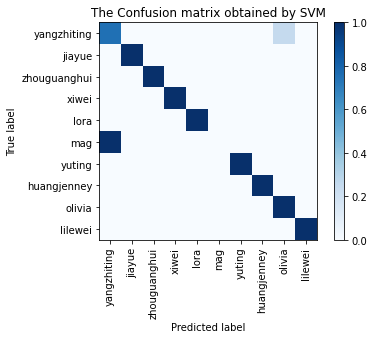

In [82]:
disp = plot_confusion_matrix(model, testX, testy, display_labels=class_names,cmap=plt.cm.Blues,normalize='true',xticks_rotation='vertical', include_values=False)
disp.ax_.set_title('The Confusion matrix obtained by SVM')

plt.show()


In [83]:
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))
accuracy_train['SVM'] = score_train*100
accuracy_test['SVM'] = score_test*100

Accuracy: train=99.367, test=94.286


In [84]:
# fit model
model = DecisionTreeClassifier(random_state=0,max_depth=5)
model.fit(trainX, trainy)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

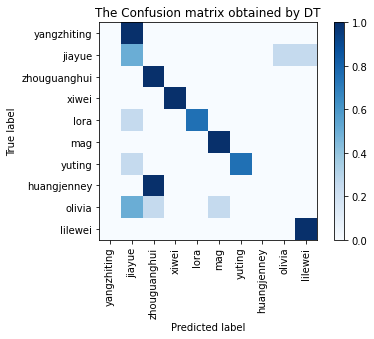

In [85]:
disp = plot_confusion_matrix(model, testX, testy, display_labels=class_names,cmap=plt.cm.Blues,normalize='true',xticks_rotation='vertical', include_values=False)
disp.ax_.set_title('The Confusion matrix obtained by DT')

plt.show()


In [86]:
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))
accuracy_train['DT'] = score_train*100
accuracy_test['DT'] = score_test*100

Accuracy: train=69.620, test=54.286


In [94]:
# fit model
model = MLPClassifier(alpha=1, hidden_layer_sizes=10, max_iter=1000)
model.fit(trainX, trainy)

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=10, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

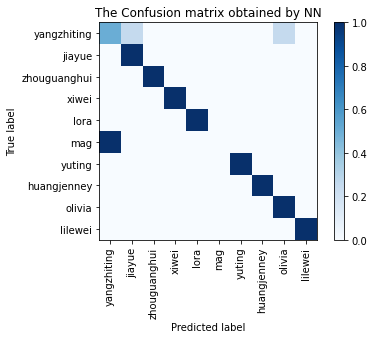

In [95]:
disp = plot_confusion_matrix(model, testX, testy, display_labels=class_names,cmap=plt.cm.Blues,normalize='true',xticks_rotation='vertical', include_values=False)
disp.ax_.set_title('The Confusion matrix obtained by NN')

plt.show()


In [96]:
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))
accuracy_train['NN'] = score_train*100
accuracy_test['NN'] = score_test*100

Accuracy: train=99.367, test=91.429


In [97]:
# fit model
model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainX, trainy)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

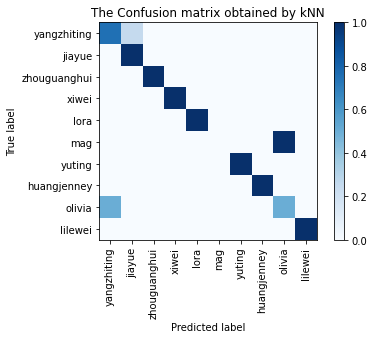

In [98]:
disp = plot_confusion_matrix(model, testX, testy, display_labels=class_names,cmap=plt.cm.Blues,normalize='true',xticks_rotation='vertical',include_values=False)
disp.ax_.set_title('The Confusion matrix obtained by kNN')

plt.show()


In [99]:
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))
accuracy_train['kNN'] = score_train*100
accuracy_test['kNN'] = score_test*100

Accuracy: train=98.734, test=88.571


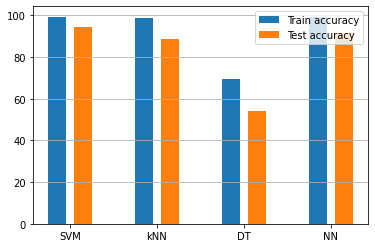

In [100]:
import matplotlib.pyplot as plt

train_ticks = range(len(accuracy_train))
test_ticks = [x+0.3 for x in range(len(accuracy_test))]
label_ticks = [x+0.15 for x in train_ticks]

plt.bar(train_ticks, list(accuracy_train.values()), align='center',width=0.2, label='Train accuracy')
plt.bar(test_ticks, list(accuracy_test.values()),width=0.2, label='Test accuracy')
plt.xticks(label_ticks, list(accuracy_train.keys()))

plt.legend(loc='best')
plt.grid(axis='y')
plt.show()
